<a id='top'></a>

# Homework 5: Confidence intervals and other things
***

**Name**: Solutions

***

This assignment is due on Moodle by **5 PM on Friday November 9**. Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do Cell $\rightarrow$ Run All as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 
- This should go without saying, but... For any question that asks you to calculate something, you **must show all work to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit.

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) | [Problem 4](#p4)

---

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
%matplotlib inline

---

<a id='p1'></a>
[Back to top](#top)

### [30 points] Problem 1 - Sea-level rise, schmee-level rise!

You have been contacted by the local government of Key West, Florida, to assess whether there is statistical evidence for sea-level rise in the area. You obtain from the University of Hawaii Sea Level Center's [gigantic repository of sea-level data](https://uhslc.soest.hawaii.edu/data/?rq) the daily mean sea levels file [linked here](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm0rl5dp6y4) and below.

In this problem, you will:
1. practice calculating confidence intervals, 
1. practice wrangling a real-life data set into a form where you can actually compute these confidence intervals, because life will rarely be so kind as to simply hand you a nicely packaged and cleaned set of data, and
1. save Key West from a watery fate?

In [117]:
# Local and web paths to the data; pick which works for you.
local_path = "data/sealevel_keywest.csv"
web_path   = "https://raw.githubusercontent.com/dblarremore/csci3022/master/homework/homework5/data/sealevel_keywest.csv"
file_path  = local_path

dfSL = pd.read_csv(file_path, header=None)
dfSL.rename(columns={0 : 'Year', 1 : 'Month', 2 : 'Day', 3 : 'SL'}, inplace=True)
dfSL.head()

,Year,Month,Day,SL
0,1913,1,20,1453
1,1913,1,21,1439
2,1913,1,22,1444
3,1913,1,23,1489
4,1913,1,24,1474


**Part A:**  Write a function `clean_data` to:
1. take in a single argument of a raw sea level data frame (e.g., `dfSL` above),
2. compute the fill-value used to replace missing sea level (SL) data (**not** hard-coded!),
3. use the Pandas `DataFrame.dropna` method to remove all missing rows of data, 
4. select only the data point on the second day of each month, and
4. return a cleaned Pandas data frame.

Use your shiny new function to clean the `dfSL` data frame and save the results in a new data frame.

There is a very specific reason to sample only one daily data point per month. We will talk about it later.

,Year,Month,Day,SL
13,1913,2,2,1409.0
41,1913,3,2,1397.0
72,1913,4,2,1402.0
102,1913,5,2,1450.0
133,1913,6,2,1490.0


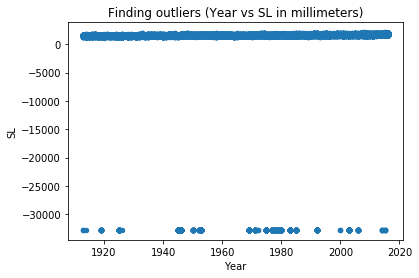

In [118]:
def clean_data(df):
    #find outliers/what should be considered null
    
    df.plot.scatter(x="Year", y="SL", title="Finding outliers (Year vs SL in millimeters)");
    #looks like anything close to -0 is okay, clearly anything past -5000 is an outlier. Should set those values to Null
    
    temp = df.copy(deep=False);
     
    #convert SL to numeric
    temp['SL'] = pd.to_numeric(temp['SL']);
    
    #convert any val in SL < 0 to NaN
    temp['SL'].mask(temp['SL'].lt(-5000),inplace=True);
    
    #Metadata says missing data flag =9999
    temp['SL'].mask(temp['SL'].eq(9999), inplace=True)
    #Drop any rows that are missing data / have NaN values
    
    temp = temp.dropna(axis=0, how='any');
 
    #Select rows associated with day==2
    dfClean = temp[temp['Day'] == 2];
   
    return dfClean

dfClean = clean_data(dfSL)
dfClean.head()


**Part B:**  Plot the cleaned time series of sea levels. Be sure to label your axes, including units. The UHSLC data portal includes a link to the metadata accompanying our data set; if you are not sure about units, that would be a good place to start looking. For the $x$-axis, place the $x$ tick marks on January 2 of each year that is divisible by 10 (i.e., 1920, 1930, ...), and label with that year. You may need to do additional processing in order to grab these indices. 

**Bonus challenge (0 points):**  Why do we choose to work with the second day of each month instead of the first?  You may need to look at the original data set to answer this.

       Year  Month  Day      SL
2538   1920      1    2  1438.0
6191   1930      1    2  1471.0
9843   1940      1    2  1477.0
13496  1950      1    2  1642.0
17148  1960      1    2  1680.0
20801  1970      1    2  1449.0
24453  1980      1    2  1579.0
28106  1990      1    2  1407.0
31758  2000      1    2  1607.0
35411  2010      1    2  1647.0


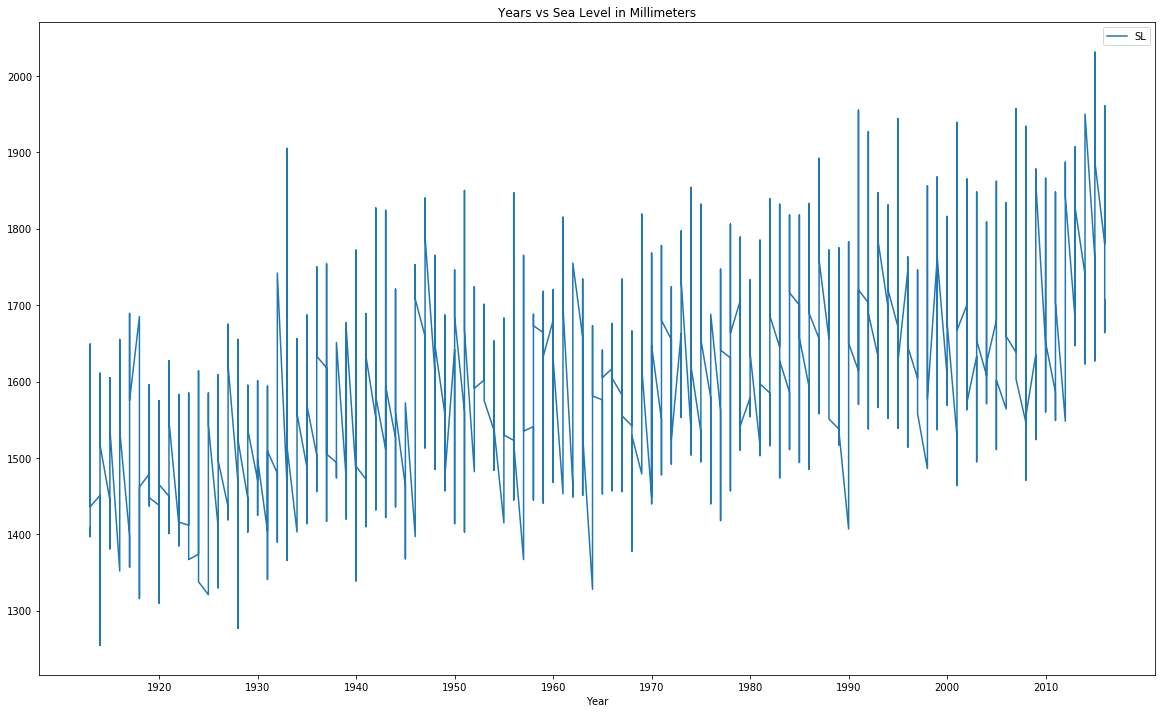

In [119]:
def plot_clean_data(df):
    dff = df.copy(deep=False);
    dff = dff.loc[(dff["Year"]%10 == 0) & (dff["Month"] == 1)]
    print(dff)
    df.plot.line(x="Year", y="SL", title="Years vs Sea Level in Millimeters", legend="reverse", xticks=dff["Year"].tolist(), figsize=(20, 12))
plot_clean_data(dfClean);

**Part C:** Use your cleaned sea levels data frame to create two new Pandas data frames or series:
1. one object to contain the sea levels between (and including) the years 1986 and 1995, and
2. another object to contain the sea levels between (and including) the years 2006 and 2015.

Then, create a single-panel figure that includes density histograms of each decade of sea levels. Be sure to label everything appropriately.

Finally, based on the data in front of you, formulate and state a hypothesis about how the mean sea level in the decade 2006-2015 compares to the mean sea level in the decade 1986-1995.

Looking at the graph below, I would assume that the mean sea level in 2006-2015 is higher and that if you were to sample a mean from either, it would be more likely to be hgiher in decade 2 (2006-15) than that of decade 1 (1986-1995).


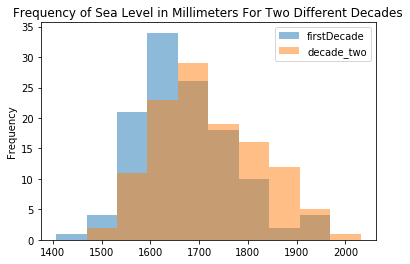

In [120]:
def comparing_sea_level_series(df, val):
    series_1986_95 = df.loc[(df['Year'] > 1985) & (df['Year'] < 1996)];
    series_2006_15 = df.loc[(df['Year'] > 2005) & (df['Year'] < 2016)];
  
    if val==True:
        temp = pd.DataFrame({'firstDecade': series_1986_95.loc[:]["SL"], 'decade_two' : series_2006_15.loc[:]["SL"]}, columns=['firstDecade','decade_two']);
        temp.plot.hist(alpha=.5, title="Frequency of Sea Level in Millimeters For Two Different Decades")
  
    return series_1986_95, series_2006_15;
comparing_sea_level_series(dfClean, True);
print("Looking at the graph below, I would assume that the mean sea level in 2006-2015 is higher and that if you were to sample a mean from either, it would be more likely to be hgiher in decade 2 (2006-15) than that of decade 1 (1986-1995).")

**Part D:** Compute a 99.9% confidence interval for each of (1) the mean sea level in the 1986-1995 decade ($\mu_{1986-1995}$) and (2) the mean sea level in the 2006-2015 decade ($\mu_{2006-2015}$).  You may use Python for arithmetic operations and executing the calculations, but the relevant steps/set-up should be displayed in Markdown/MathJax.

Based on these two confidence intervals, do you think there is sufficient evidence to conclude that there is or is not a significant difference in the mean sea level between 1986-1995 and 2006-2015? Justify your answer. 

**SETUP**  

mean sea level 1986-1995 decade: $\mu_{1986-1995}$    
  
$$ \begin{align}
   \overline{x}_{first-decade} \pm z_{ \frac{\alpha}{2} } * \frac{\sigma}{\sqrt{n}}
    \end{align}
$$
mean sea level 2006-2015 decade $\mu_{1986-1995}$  
  
$$ \begin{align}
   \overline{x}_{second-deacde} \pm z_{ \frac{\alpha}{2} } * \frac{\sigma}{\sqrt{n}}
    \end{align}
$$

In [121]:
first_decade, second_decade = comparing_sea_level_series(dfClean, False)
#first decade computations
first_mean = np.mean(first_decade)['SL']
first_std = np.std(first_decade)['SL']
n1 = len(first_decade['SL'])
first_z = stats.norm.ppf(.999)
X1_upper = first_mean + first_z*(first_std / np.sqrt(len(first_decade['SL'])));
X1_lower = first_mean - first_z*(first_std / np.sqrt(len(first_decade['SL'])));
print("Confidence Interval for first_decade with 99.9%% accuracy is [%f , %f] " % (X1_lower, X1_upper))


#second decade computations
second_mean = np.mean(second_decade)['SL']
second_std = np.std(second_decade)['SL']
n1 = len(second_decade['SL'])
second_z = stats.norm.ppf(.999)
X2_upper = second_mean + second_z*(second_std / np.sqrt(len(second_decade['SL'])));
X2_lower = second_mean - second_z*(second_std / np.sqrt(len(second_decade['SL'])));
print("Confidence Interval for first_decade with 99.9%% accuracy is [%f , %f] " % (X2_lower, X2_upper))



Confidence Interval for first_decade with 99.9% accuracy is [1642.902639 , 1698.247361] 
Confidence Interval for first_decade with 99.9% accuracy is [1689.566491 , 1751.789441] 


Based on these two confidence intervals, do you think there is sufficient evidence to conclude that there is or is not a significant difference in the mean sea level between 1986-1995 and 2006-2015? Justify your answer. 

**Part E:**  Compute a 99.9% confidence interval for the ***difference in mean sea level*** between the 2006-2015 and the 1986-1995 decades ($\mu_{2006-2015} - \mu_{1986-1995}$. Based on this, make a conclusion regarding your hypothesis from **Part C**, and compare to what your results in **Part D** implied. You may use Python for arithmetic operations and executing the calculations, but the relevant steps/set-up should be displayed in Markdown/MathJax.

$$\begin{aligned}
    \overline{x} - \overline{y} \pm z_{\frac{\alpha}{2}} * \sqrt{ \frac{\sigma_1^{2}}{m} + \frac{\sigma_2^{2}} {n} }
\end{aligned}
$$

In [122]:
def difference_in_means(df1, df2):
    first_mean = np.mean(df1)['SL'];
    first_std = np.std(df1)['SL'];
    m = len(first_decade['SL']);
    
    second_mean = np.mean(df2['SL']);
    second_std = np.std(df2['SL'])
    n = len(df2['SL'])
    
    z = stats.norm.ppf(.999);
    
    #compute the difference in mean CI
    XY = first_mean - second_mean;
    est_std = np.sqrt( (first_std / m) + (second_std / n))
    
    XY_upper = XY + z*est_std;
    XY_lower = XY - z*est_std;
    
    print("Confidence Interval for the difference in means with 99.9%% accuracy is [%f , %f] " % (XY_lower, XY_upper))
    

difference_in_means(first_decade, second_decade);

print("based on a negative value of the first_decade_mean: %f - second_decade_mean: %f being negative,or by the range being negative, it means that the second decade has a higher mean to 99.9%% confidence." % (np.mean(first_decade['SL']), np.mean(second_decade['SL'])))
print("This means that we can infer that sea levels are in fact, rising. (compared from the first decade to the second)");

Confidence Interval for the difference in means with 99.9% accuracy is [-54.184251 , -46.021681] 
based on a negative value of the first_decade_mean: 1670.575000 - second_decade_mean: 1720.677966 being negative,or by the range being negative, it means that the second decade has a higher mean to 99.9% confidence.
This means that we can infer that sea levels are in fact, rising. (compared from the first decade to the second)


**Part F:**  The confidence intervals from **Parts D** and **E** were derived using the Central Limit Theorem.  Which assumption of the Central Limit Theorem would likely be violated if we took more than one measurement per month to form our samples, and why?

We would start to have prior information about consecutive data points. Meaning that we now have dependencies on the probability of the sea level being X height when the day before it was Y height. (ex.: if we know on January 2nd that SL = 5.01 meters, there is a really high liklihood that the next day it will be very close to that same measurement)

---

<a id='p2'></a>
[Back to top](#top)

### [25 points] Problem 2 - Quality of Red vs White Wine 

**Part A:** Load the data in [`winequalityred.csv`](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm1ebc6q6ye) and [`winequalitywhite.csv`](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm17x9pu6y9) into Pandas DataFrames.  They are available under Resources on Piazza, and linked here and below.  A description of this dataset can be found on [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). The quantity of interest for this problem is the quality of the wine.

Are we justified in using the Central Limit Theorem in our analysis of estimates of the mean and proportions of the data?  Justify your response. 

In [123]:
# read either local or web file version; pick whichever works for you
local_file_white = "data/winequality-white.csv"
local_file_red   = "data/winequality-red.csv"
web_file_white = "https://raw.githubusercontent.com/dblarremore/csci3022/master/homework/homework5/data/winequality-white.csv"
web_file_red   = "https://raw.githubusercontent.com/dblarremore/csci3022/master/homework/homework5/data/winequality-red.csv"

dfRed   = pd.read_csv(web_file_red, delimiter=';')
dfWhite = pd.read_csv(local_file_white, delimiter=';')

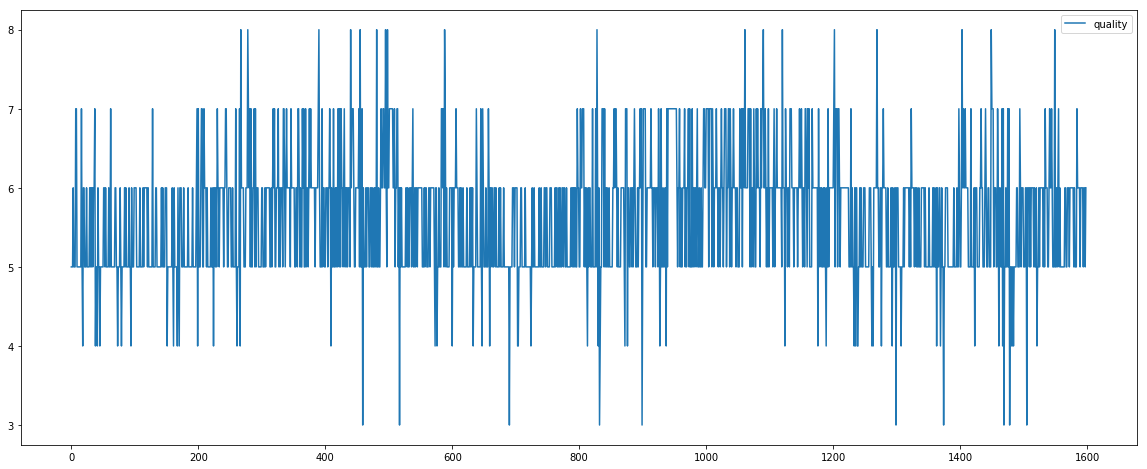

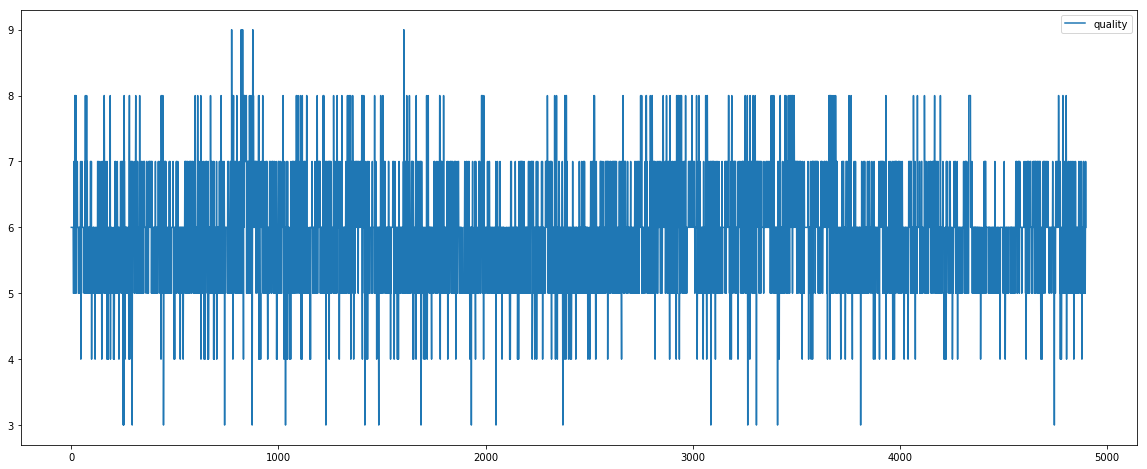

In [124]:
dfRed.plot(y="quality", use_index=True, figsize=(20,8))
dfWhite.plot(y="quality", use_index=True, figsize=(20,8))

** USING THE ABOVE GRAPHS **  
We can see that there are quite a low amount of outliers compared to the majority of the distributed data. Most of the data is within the 4-8 range which I think that means it's a good indicator that this distribution will be good for the CLT to be used. 

**Part B:** Let $X$ be a random variable denoting the quality of a bottle of wine, and let $C$ be a random variable denoting its color (either red ($r$) or white ($w$)). For the remainder of this problem, we are concerned with probabilities such as "If I buy a random bottle of red wine, what is the probability that its quality is at least a 7?". We could write that probability as $P(X \geq 7 \mid C=r)$, for example, and consider it the ***proportion*** of the population of red wines that are at least a 7 in quality. Calculate and report estimates of $P(X \geq 7 \mid C=r)$ and $P(X \geq 7 \mid C=w)$.

Obtain 95% confidence intervals for the proportion of red and white wines that are **at least** a 7 in quality (obtain one CI for each color).  Based on your results, if you are interested in buying many high quality bottles of wine but are buying totally at random, is one color a better bet than the other? Fully justify your answer.

Calculations may be executed in Python, but you need to set up your work (*what* it is you are calculating) in Markdown/MathJax.

** Proportions: **  
$$ \begin{align}
   \hat{p} =  \frac{\text{number of wines that are quality=> 7}}{\text{total number of wines}}\\ 
   \text{Then we can obtain the confidence interval as: }\\
   \hat{p} \pm z_{\alpha / 2} * \sqrt{\frac{\hat{p} * (1-\hat{p})}{n} }
   \end{align}
$$

In [125]:

#95% confidence interval



def proportion(df, min_quality):
    #Just a single estimate would be quality>=7 / n
    sample_prop = df[df['quality'] >= min_quality];
    prop_p = len(sample_prop) / len(df)
    return prop_p;

def prop_confidence_interval(df, prop_p, confidence):
        p = prop_p;
        alpha = 1-confidence;
        alpha = alpha/2;
        z = stats.norm.ppf(1-alpha);
        intval = (z* np.sqrt((p*(1-p))/df['quality'].count()))
        
        lower = p-intval;
        
        upper = p+intval;
        return (lower, upper);

        


print("proportion of red wines that are of quality 7 of greater is %f " %proportion(dfRed, 7))
print("proportion of white wintes that are of quality 7 of greater is %f " %proportion(dfWhite, 7))
red_lower, red_upper = prop_confidence_interval(dfRed, proportion(dfRed,7), .95)
print("Probability of choosing a good red wine with quality 7 or greater is [%f, %f] " % (red_lower, red_upper))
white_lower, white_upper = prop_confidence_interval(dfWhite, proportion(dfWhite,7), .95)
print("Probability of choosing a good white wine with quality 7 or greater is [%f, %f] " % (white_lower, white_upper))

proportion of red wines that are of quality 7 of greater is 0.135710 
proportion of white wintes that are of quality 7 of greater is 0.216415 
Probability of choosing a good red wine with quality 7 or greater is [0.118923, 0.152496] 
Probability of choosing a good white wine with quality 7 or greater is [0.204882, 0.227947] 


**I would say that buying a white wine will yield a higher probaiblity with a 95% confidence level of observing that probability. **

**Part C:** Now, as college students (and teachers), we might not be super concerned with buying a really high quality bottle of wine.  Let's focus instead on making sure we do *not* buy a really disgusting bottle of wine.  Calculate and report estimates of $P(X \geq 5 \mid C=r)$ and $P(X \geq 5 \mid C=w)$.

Obtain 95% confidence intervals for the proportion of red and white wines that are **at least** a 5 in quality, that is, $P(X \geq 5 \mid C)$.  Based on your results - and what you saw in Problem 1 - if you are interested in buying bottles of wine that are at least a 5 in quality, but are again buying wine totally randomly, can you conclude that you are better off buying one color over the other? Fully justify your answer.

In [150]:
red_5_p = proportion(dfRed, 5);
white_5_p = proportion(dfWhite, 5);



r5_L, r5_U = prop_confidence_interval(dfRed, red_5_p, .95)
print("Probability of choosing a good red wine with quality 5 or greater is [%f, %f] " % (r5_L, r5_U))
w5_L, w5_U = prop_confidence_interval(dfWhite, white_5_p, .95)
print("Probability of choosing a good red wine with quality 5 or greater is [%f, %f] " % (w5_L, w5_U))


Probability of choosing a good red wine with quality 5 or greater is [0.951065, 0.970136] 
Probability of choosing a good red wine with quality 5 or greater is [0.957327, 0.967949] 


I think that you wouldn't really have a better option as the confidence intervals overlap and thus in my opinion don't have a significant difference. 

**Part D:** Compute a 95% confidence interval for the difference in proportions of red and white wines that are at least a 5 in quality. 

Now, based on your results for this part, can you conclude that you are better off buying one color over the other? Fully justify your answer. How does your work here differ from your work in **Part C**?

In [159]:
def dif_between_props(n_1, prop_1, n_2, prop_2,confidence):
    
    p1 = prop_1
    p2 = prop_2
   
    alpha = 1-confidence;
   
    z = stats.norm.ppf(confidence+(alpha/2))
 
    np1 = float((p1*(1-p1))/n_1)
    np2 = float((p2*(1-p2))/n_2)
    intval = z * np.sqrt((np1 + np2))
 
      
    
    
    lower = (p1-p2)-intval;
    upper = (p1-p2) + intval;
    return lower,upper

diff_lower, diff_higher = dif_between_props(len(dfRed), red_5_p, len(dfWhite), white_5_p, .95)


print("I am 95%% confident that the difference between the proportion of a Red wine and a White wine being of a quality of 5 or higher is [%f, %f] " % (diff_lower, diff_higher))

I am 95% confident that the difference between the proportion of a Red wine and a White wine being of a quality of 5 or higher is [-0.012952, 0.008877] 


** Because that we have 0 in the middle, we know that there is 0 difference in this interval. We thus know there is NOT a "significant difference" between two proportions. ** 

**Part E:**  Now, we have many more observations of white wines than red. This certainly contributes to the width of the 95% confidence interval for the proportion of red wines that are at least a 5 in quality, which you should have found in **Part C** to be wider than the corresponding confidence interval for white wines. 

How large would our sample size of red wines need to be in order to guarantee that this 95% confidence interval width is at most 0.01? Note that we are hypothetically adding more samples, so we do not know the precise value of $\hat{p}$.

**We would use the following formula to find the same size where n =  sample size, m = interval width**  

$$ \begin{align}
    n \ge (\frac{z_{\sigma/2}}{m}) * p^*(1-p^*)  
    \end{align}
$$

In [170]:
def find_sample_size(m, p, conf):
    #p(1-p)
    p = p*(1-p)
    width_z = stats.norm.ppf(conf+((1-conf)/2))/m
    n = p*(width_z**2)
    return n
samples_needed = find_sample_size(.01, red_5_p, .95)
#round up
samples_needed = int(np.ceil(samples_needed))
print("The number of samples we need to provide a confidence interval of 95%% with interval width at most .01 is %i " % samples_needed)

The number of samples we need to provide a confidence interval of 95% with interval width at most .01 is 1454 


---

<a id='p3'></a>
[Back to top](#top)

### [30 points] Problem 3 - Exploring Confidence Intervals 

The [Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution) distribution is one of several distributions frequently used to model environmental extremes (for example, extreme temperatures and sea levels).  It is also fairly asymmetric, and thus interesting for investigating confidence intervals.  It is implemented in scipy.stats as [gumbel_r](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_r.html), where the appendix "\_r" denotes the right-skewed version of the Gumbel distribution (as opposed to the left-skewed).

**Part A**: Complete the following code cell to plot a histogram of 100 realizations from the Gumbel distribution with parameters $\mu=8$ and $\beta=2$.  Be sure to leave this cell executed before turning in your assignment! Make your histogram grey with gold edges.

In [ ]:
mu = 8
beta = 2
n_sample = 100
# your code here

**Part B:** Look up the analytical mean and variance of the Gumbel distribution with parameters $\mu=8$ and $\beta=2$ and calculate them here by hand.  Note that the Euler–Mascheroni constant can be accessed via `np.euler_gamma`. 

Use the empirical mean from your sample in **Part A**, and the true variance of the Gumbel distribution to compute by hand a 95% confidence interval for the mean.

**Part C:  A theoretical interlude.** When Stella O'Flaherty (the famous octopus) ran her solution code for **Part B**, she obtained a 95% confidence interval of $[8.81, 9.82]$ for the mean of the $Gum(\mu=8, \beta=2)$ distribution. For each of the following, explain why or why not the situation described is correct, given the technical definition of a 95% confidence interval we went over in class.

**(i)** If you had no other evidence regarding true mean of the $Gum(\mu=8, \beta=2)$ distribution, you could say there is a 95% chance that its true mean falls between 8.81 and 9.82.

**(ii)** If a class of 100 students all construct 95% confidence intervals for the mean of the $Gum(\mu=8, \beta=2)$ distribution, then we expect about 95 of their CIs to contain the true mean, and about 5 of them to miss the true mean.

**(iii)** There is a 95% probability that any given random variable sampled from $Gum(\mu=8, \beta=2)$ will be between 8.81 and 9.82.

**Part D:** In this part you'll write a function to investigate the _coverage properties_ of a confidence interval for the mean of the Gumbel distribution. Complete the following function to randomly sample $m=500$ sample means with sample size $n=100$ for the Gumbel distribution with parameters $\mu=8$ and $\beta=2$.  For each random sample, compute the 66% confidence interval for the mean. Note that you actually know that the variance for the true population distribution is, $\sigma^2$.  Your function should do two things: 

1. Report the proportion of confidence intervals that successfully cover the true mean of the distribution 
2. Make a plot of 50 randomly selected confidence intervals. Overlay the intervals on the line $y=\textrm{True mean}$ (from **Part B**). Color confidence intervals black if they cover the true mean, and red if they don't.  

Be sure to leave this cell executed before turning in your assignment!

In [ ]:
def confidence_intervals(m=500, n=100):
    mu = 8
    beta = 2
    # Your code here
    proportion_CIs_covering_mean = 0
    print("proportion covering mean: {:.3f}".format(proportion_CIs_covering_mean))
    
    
confidence_intervals()

**Part E:** Does the proportion of confidence intervals that cover the true mean of the distribution agree with the theory described in class?  Justify your conclusion. 

---

<a id='p4'></a>
[Back to top](#top)

### [15 points] Problem 4 - Freethrows
***

Keep your skills sharp by answering these straightforward questions.

**Part A**: <font color='green'>You are driving through the paint toward the basket when Steph Curry fouls you. You step to the line to sink this freethrow shot, which is delivered in the form of a CSCI3022 problem:</font>

You have a shuffled deck of cards. It includes the usual 52 cards AND three special additional Octopus cards. You flip over the cards one by one, without replacing them in the deck. You count how many cards you'll have to flip until you flip over the second Octopus.  You repeat this many times. Simulate this process. Plot a histogram with binsize=1 of the outcomes, in lightgrey with white outline. Compute the mean, median, and mode for this dataset, indicate them on the plot too, using linstyles of green dashed, pink dotted, and black solid, respectively. Look up how to do a legend in MatPlotLib, and label your histogram, mean, median.
***

**Part B**: <font color='green'>You sink your first free throw and immediately get dap from your teammates, Oscar O'Flaherty and Octavia O'Flaherty. You prepare to take another shot, which—and you're not going to believe this—is another CSCI3022 problem:</font>

In general, which is wider: a 95% confidence interval or a 99% confidence interval? How would you explain this to your younger sibling, who is not a statistician?
***

**Part C**: <font color='green'>The crowd is silent. Everything is slow motion. You're literally in the air, releasing what looks to be a perfect shot to tie the match. As you release the ball, a hand appears to block it. It is Kevin Durant. :( 

Luckily, his fingertips also brush against your arm. That's a foul, and everyone saw it. Back to the line. Back to CSCI3022:</font>

Let $X$ be a normally-distributed random variable. You draw from it and get these values, stored in the numpy array **durant**, below. Compute a 95% confidence interval for the _standard deviation_.
***

In [ ]:
durant = np.array([3.7778,3.9459,3.8248,4.1111,4.0180,4.0898,4.0380,3.9273,3.9614,3.8387])

**Part D**: <font color='green'>"Draymond Green has it all, in spite of living in the Bay Area," you think to yourself. "But he doesn't have this shot..." You're all over him, and he's going to have to pass. You can see the irritation in his eyes. Then you realize that it's not irritation, and he's not being distracted by your superb defense. He's being distracted by this CSCI3022 problem:</font>

If you're doing quality control for the average strength of carbon fiber that will be used in airplane construction, and your alternative hypothesis is that the strength of the carbon is below tolerance, and therefore unsafe, would you rather have a low Type I error rate or a low Type II error rate? Explain.

***

**Part E**: <font color='green'>You are watching tape footage at halftime with your personal trainer, Stella O'Flaherty. You gotta focus up if you're going to match Klay Thompson's speed in the second half. You take a sip of Gatorade and Dr. O'Flaherty suggests that you do the following CSCI3022 problem:</font>

You measure 53 suckers from baby reef octopuses and find that they are, on average, 45.2 mm wide, with a standard devaition of 30.4mm. 

Then you measure 41 suckers from from baby dumbo octopuses and find that they are, on average, 52.8 mm wide, with a standard deviation of 22.8 mm. 

Is there statistical evidence at the 0.05 significance level that the true mean of baby dumbo octopus sucker width exceeds the true mean of baby reef octopus sucker width by more than 6 mm?  Use a test of your choice.

***